# Задание

Для закрепления материала модуля предлагаем вам выполнить следующий проект ↓

Вам необходимо решить задачу нахождения похожих товаров в интернет-магазинах по их описанию.

На практике похожую задачу с помощью организации Kaggle-соревнования решал маркетплейс https://shopee.co.id/.

ccsлка на датасет - https://www.kaggle.com/datasets/cclark/product-item-data

______

**Для каждого id товара необходимо сформировать список id товаров, которые похожи на него.**

ПРИМЕРНЫЙ ПЛАН ВЫПОЛНЕНИЯ ПРОЕКТА:

- Представьте массив текстов в виде векторов (как с помощью TF-IDF, так и с помощью Word2Vec).
- Выберите расстояние, с помощью которого вы будете оценивать близость векторов, представляющих тексты (рекомендуется использовать косинусное расстояние, но вы можете попробовать и другие подходы).
- Для полученных векторов попарно найдите косинусное расстояние (попробуйте сделать это без цикла, с помощью матричных операций).
- Задайте какой-то порог значимости (с которым вы сравните значения расстояния между векторами), на основе которого вы будете судить о том, похожи два текста или нет.

# Подключение к Kaggle

In [1]:
api_token = {"username":"...","key":"..."}

import json

with open('/content/kaggle.json', 'w') as file:
  json.dump(api_token, file)

In [2]:
# Загрузка датасета с Кеггла
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.12 -q
!kaggle --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 900.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Kaggle API 1.5.12


# Загрузка данных соревнования

In [3]:
!kaggle datasets download -d cclark/product-item-data
!unzip '/content/product-item-data.zip' -d'/content/data/'

  0% 0.00/137k [00:00<?, ?B/s]
100% 137k/137k [00:00<00:00, 76.3MB/s]
Archive:  /content/product-item-data.zip
  inflating: /content/data/sample-data.csv  


In [4]:
import pandas as pd
import numpy as np

In [5]:
products = pd.read_csv('/content/data/sample-data.csv', index_col='id')
print(f'Dataset shape {products.shape}')
print()
products.sample(15)


Dataset shape (500, 1)



,description
id,
83,Lw travel duffel - This wanderer's bag is larg...
414,Duality jkt - Like the spring weather in Michi...
209,"Nine trails shorts - Mountain biking, trail ru..."
269,Merino 2 t-shirt - Our most versatile merino b...
157,All-out capris - Jam a pair of these highly co...
237,Wheat t-shirt - Feeding urban and agrarian sen...
261,"Print paries btm - Styled like a boy short, ou..."
54,Highwater pfd vest - The constant boat angling...
192,Lithia dress - Celebrate the Summer Solstice w...


In [6]:
def clear_discription(elements):
  '''
  Функция очистки описаний от лишних техничеких символов
  и знаков препинаний и с переводом к малым буквам
  '''
  cleared = []
  for element in elements:
    res = ''
    for part in element.split('-'):
      res += ' '.join(''.join(filter(str.isalnum, line)) for line in part.split()).lower()
      res += ' '
    cleared.append(res)
  return cleared

In [7]:
smpl = products.description.tolist()[10]
print(smpl)

Baby sunshade top - Soft, stretchy polyester fabric is fast wicking, quick drying and breathable <br><br><b>Details:</b><ul> <li>Lap shoulders relax the silhouette </li> <li>Extended roll-down cuffs accommodate growth spurts; drop hem waist provides extra coverage</li></ul><br><br><b>Fabric: </b>4.3-oz 100% polyester jersey. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(0 g 0 oz)<br><br>Made in Vietnam.


In [8]:
print(clear_discription([smpl])[0])

baby sunshade top soft stretchy polyester fabric is fast wicking quick drying and breathable brbrbdetailsbul lilap shoulders relax the silhouette li liextended roll down cuffs accommodate growth spurts drop hem waist provides extra coverageliulbrbrbfabric b43 oz 100 polyester jersey recyclable through the common threads recycling programbrbrbweight b0 g 0 ozbrbrmade in vietnam 


# Получаем вектора на основе tfidf и word2vec

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Создание TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer()

goods = products.description.tolist()
# читска описаний
goods = clear_discription(goods)

# Преобразование текстовых документов в матрицу TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(goods).toarray()

# Создание модели Word2Vec
word2vec_model = Word2Vec([doc.lower().split() for doc in goods], min_count=1)

# Преобразование текстовых документов в векторы Word2Vec
word2vec_vectors = np.array([np.mean([word2vec_model.wv[word] for word in doc.lower().split() if word in word2vec_model.wv]
                                    or [np.zeros(word2vec_model.vector_size)], axis=0)
                            for doc in goods])

# Смотрим
print(f"TF-IDF векторы размерность: {tfidf_matrix.shape}")
print(f'\nWord2Vec векторы размерность: {word2vec_vectors.shape}')

TF-IDF векторы размерность: (500, 6173)

Word2Vec векторы размерность: (500, 100)


## Получаем совместные вектора из tfidf и word2vec

In [10]:
# Соединяем в расширенные векторы из Word2Vec и TF_IDF
tfidf_w2v_vectors = np.hstack((tfidf_matrix,word2vec_vectors))
print(f"TF-IDF-W2V векторы размерность: {tfidf_w2v_vectors.shape}")


TF-IDF-W2V векторы размерность: (500, 6273)


# KMEANS CLUSTERING

In [11]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import pdist

## with cosine_dist_tfidf

### Матрицы косинусных расстояний из tfidf

In [12]:
# Нормализация векторов по строкам (приведение к единичной длине)
normalized_vectors = tfidf_matrix / np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)

# Вычисление косинусного расстояния
cosine_dist_tfidf = cosine_distances(normalized_vectors)

# Вывод матрицы косинусных расстояний
print("Матрица косинусных расстояний:")
print(cosine_dist_tfidf)

Матрица косинусных расстояний:
[[0.         0.75566203 0.87182637 ... 0.88516878 0.86242108 0.88010156]
 [0.75566203 0.         0.50793671 ... 0.94107467 0.87389176 0.91922526]
 [0.87182637 0.50793671 0.         ... 0.91852904 0.93316166 0.94415745]
 ...
 [0.88516878 0.94107467 0.91852904 ... 0.         0.92486872 0.91738958]
 [0.86242108 0.87389176 0.93316166 ... 0.92486872 0.         0.54070767]
 [0.88010156 0.91922526 0.94415745 ... 0.91738958 0.54070767 0.        ]]


### Поиск оптимального к-ва кластеров

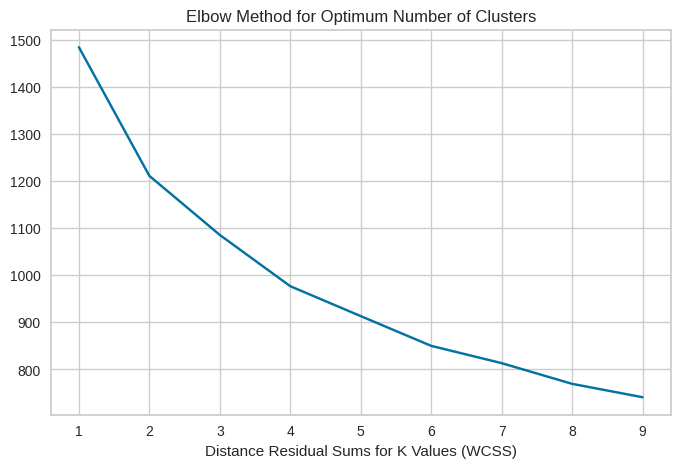

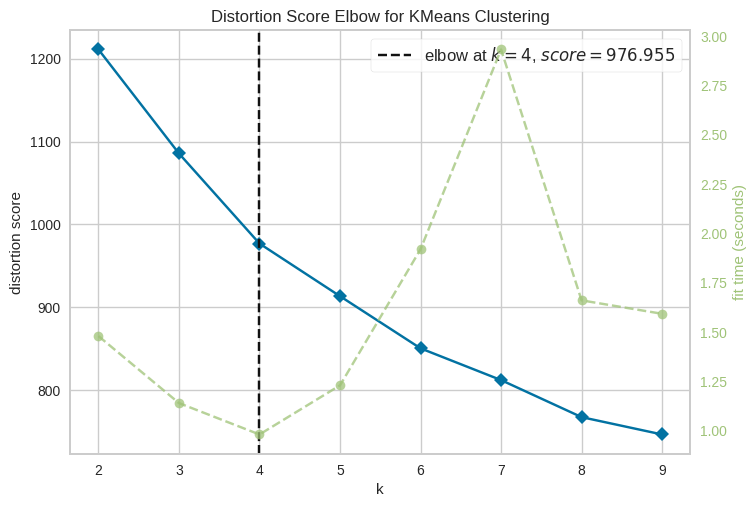

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
# KMeans Clustering
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(cosine_dist_tfidf)
    ssd.append(kmeans.inertia_)

ssd
fig = plt.figure(figsize=(8, 5))
plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 10))
visu.fit(cosine_dist_tfidf)
visu.show()

In [14]:
elbow_clusters = visu.elbow_value_
print(f'Best elbow quanty cluster {elbow_clusters}\n')
kmeans = KMeans(n_clusters=elbow_clusters).fit(cosine_dist_tfidf)
clusters = kmeans.labels_

products["cluster_tfidf"] = clusters
products.head()

Best elbow quanty cluster 4



,description,cluster_tfidf
id,,
1,Active classic boxers - There's a reason why o...,2
2,Active sport boxer briefs - Skinning up Glory ...,3
3,Active sport briefs - These superbreathable no...,3
4,"Alpine guide pants - Skin in, climb ice, switc...",1
5,"Alpine wind jkt - On high ridges, steep ice an...",1


In [15]:
products.cluster_tfidf.value_counts()

3    230
1    154
0     60
2     56
Name: cluster_tfidf, dtype: int64

In [16]:
for cls in products.cluster_tfidf.value_counts().index:
  print(f'label_tfidf {cls}')
  print(products[products.cluster_tfidf == cls].sample(5).description)
  print()


label_tfidf 3
id
10     Baby sun bucket hat - This hat goes on when th...
165    Barely bikini - Better than going commando, ou...
192    Lithia dress - Celebrate the Summer Solstice w...
158    All weather training top - Whether you're hitt...
345    Versatiliti polo - Civilized, but ready for ac...
Name: description, dtype: object

label_tfidf 1
id
409    Boardie shorts - Let your grom rip, tear and s...
5      Alpine wind jkt - On high ridges, steep ice an...
395    Wavefarer board shorts-21 in. - The board shor...
302    All-time shell - Since rain is recycled we fig...
204    Micro puff vest - Too many alpine shiver-fests...
Name: description, dtype: object

label_tfidf 0
id
102    Planer t-shirt - The Planer T-Shirt gives a no...
377    Quiet please t-shirt - Thoreau said that "sile...
476    Baby tag you're it t-shirt - It's not fair: Th...
493    '73 logo t-shirt - Patagonia's timeless '73 Lo...
334    Live simply deer t-shirt - Adaptability is sim...
Name: description, dtype: 

### Посмотрим распределение расстояний в кластерах

label_tfidf 0
max_cosdist_tfidf 0.9102282073915412

label_tfidf 1
max_cosdist_tfidf 0.9489873226686398

label_tfidf 2
max_cosdist_tfidf 0.9020854963009122

label_tfidf 3
max_cosdist_tfidf 0.9921222762996



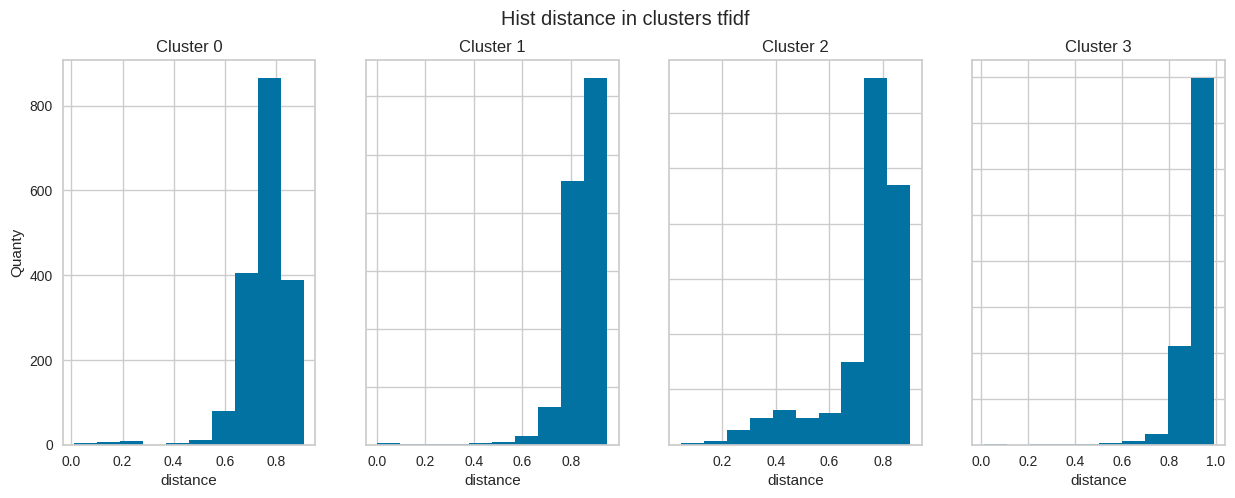

In [17]:
# составим матрицу внутри каждого кластера и выведим макс. расстояния пар
u_labels = sorted(products.cluster_tfidf.value_counts().index)

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(1, len(u_labels), figsize=(15, 5))
fig.suptitle('Hist distance in clusters tfidf')

# идем по кластерам
for cls in u_labels:
    print(f'label_tfidf {cls}')
    goods_cluster = products[products.cluster_tfidf == cls].description.tolist()
    # читска описаний
    goods_cluster = clear_discription(goods_cluster)

    # Преобразование текстовых документов в матрицу TF-IDF
    tfidf_matrix_ = tfidf_vectorizer.fit_transform(goods_cluster).toarray()

    # Нормализация векторов по строкам (приведение к единичной длине)
    normalized_vectors = tfidf_matrix_ / np.linalg.norm(tfidf_matrix_, axis=1, keepdims=True)
    # Вычисление косинусного расстояния
    cosine_dist_tfidf = cosine_distances(normalized_vectors)

    print(f'max_cosdist_tfidf {cosine_dist_tfidf.max()}\n')

    pair_dist = pdist(tfidf_matrix_, 'cosine')
    axs[cls].set_title(f'Cluster {cls}')
    axs[cls].hist(pair_dist)

# подписи осей
for ax in axs.flat:
    ax.set(xlabel='distance', ylabel='Quanty')
# уберем лишние надписи на осях
for ax in axs.flat:
    ax.label_outer()


### Отрисуем с PCA

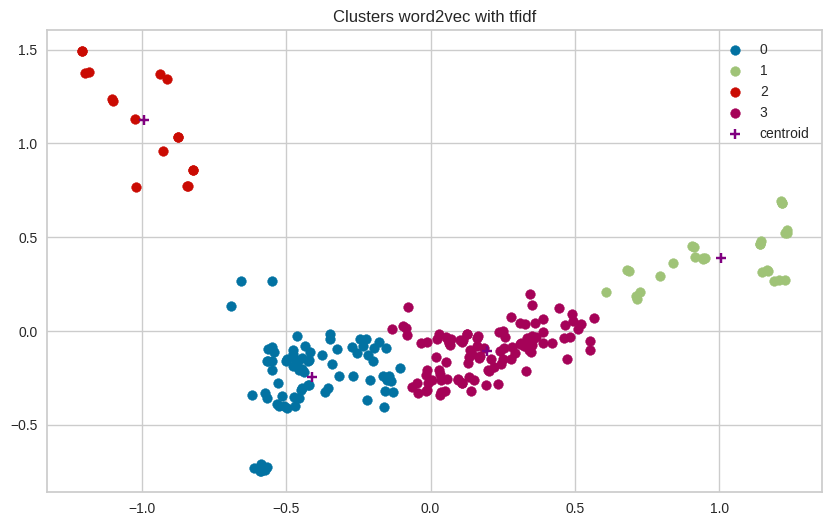

In [18]:
from sklearn.decomposition import PCA

pca = PCA(2)
#Transform the data
transform = pca.fit_transform(cosine_dist_tfidf)
kmeans = KMeans(n_clusters= elbow_clusters)
label = kmeans.fit_predict(transform)

#plotting the results:
plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i, 0],
                transform[label == i, 1] ,
                label = i)
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            color='purple',marker='+',
            label='centroid')
plt.legend()
plt.title('Clusters word2vec with tfidf')
plt.show()

## with cosine_dist_word2vec

### Матрицы косинусных расстояний из word2vec

In [19]:
# Нормализация векторов по строкам (приведение к единичной длине)
normalized_vectors = word2vec_vectors / np.linalg.norm(word2vec_vectors, axis=1, keepdims=True)

# Вычисление косинусного расстояния
cosine_dist_w2v = cosine_distances(normalized_vectors)

# Вывод матрицы косинусных расстояний
print("Матрица косинусных расстояний w2v:")
print(cosine_dist_w2v)

Матрица косинусных расстояний w2v:
[[0.         0.00078344 0.00175595 ... 0.02152312 0.00321847 0.00209689]
 [0.00078344 0.         0.00143081 ... 0.02655089 0.00142628 0.00078338]
 [0.00175595 0.00143081 0.         ... 0.01852292 0.00255287 0.00372869]
 ...
 [0.02152312 0.02655089 0.01852292 ... 0.         0.03260076 0.03315413]
 [0.00321847 0.00142628 0.00255287 ... 0.03260076 0.         0.00129843]
 [0.00209689 0.00078338 0.00372869 ... 0.03315413 0.00129843 0.        ]]


### Поиск оптимального к-ва кластеров

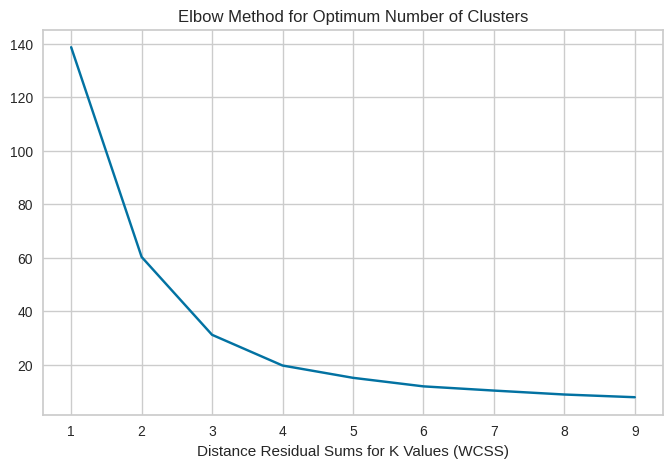

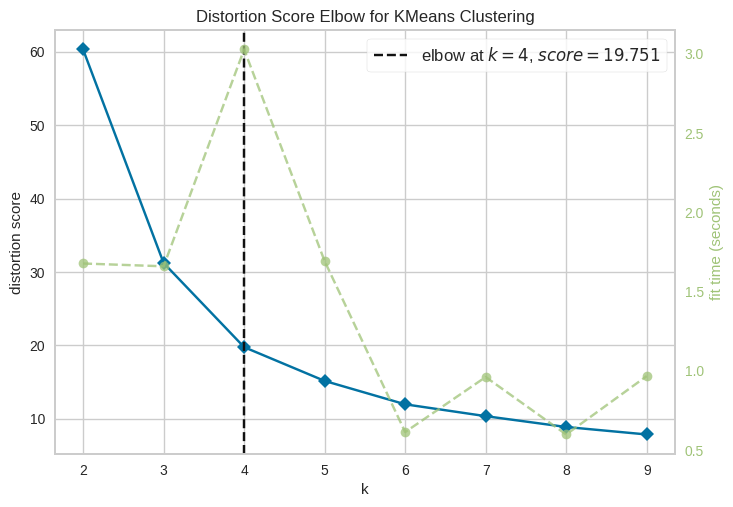

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(cosine_dist_w2v)
    ssd.append(kmeans.inertia_)

ssd
fig = plt.figure(figsize=(8, 5))
plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 10))
visu.fit(cosine_dist_w2v)
visu.show()

In [21]:
elbow_clusters = visu.elbow_value_
print(f'Best elbow quanty cluster {elbow_clusters}\n')
kmeans = KMeans(n_clusters=elbow_clusters).fit(cosine_dist_w2v)
clusters = kmeans.labels_

products["cluster_w2v"] = clusters
products.head()

Best elbow quanty cluster 4



,description,cluster_tfidf,cluster_w2v
id,,,
1,Active classic boxers - There's a reason why o...,2,3
2,Active sport boxer briefs - Skinning up Glory ...,3,3
3,Active sport briefs - These superbreathable no...,3,3
4,"Alpine guide pants - Skin in, climb ice, switc...",1,0
5,"Alpine wind jkt - On high ridges, steep ice an...",1,0


In [22]:
products.cluster_w2v.value_counts()

3    162
0    147
1    108
2     83
Name: cluster_w2v, dtype: int64

In [23]:
for cls in products.cluster_w2v.value_counts().index:
  print(f'label_w2v {cls}')
  print(products[products.cluster_w2v == cls].sample(5).description)
  print()


label_w2v 3
id
225    S/s a/c shirt - Not even stifling Great Basin ...
34     Delivery shorts - Locals know all the best spo...
335    Live simply guitar t-shirt - Live life unplugg...
74     Logo hat - Your unflappable road-tripping comp...
198    Mandeville hoody - A going-places hoody. The M...
Name: description, dtype: object

label_w2v 0
id
15     Borderless shorts-11 in. - Go forward where ot...
330    Borderless zip-off pants - Worn as capris on o...
379    Lw guide pants - A backcountry version of our ...
114    Riverwalker - studded - High water. Slick bedr...
434    Girl's t-back one piece - A girl's trusted com...
Name: description, dtype: object

label_w2v 1
id
373    Permit silhouette t-shirt - The Permit's scyth...
289    Owlin around t-shirt - The Owlin' Around T-Shi...
73     Live simply guitar t-shirt - Live life unplugg...
251    Simply organic top - When Spring's first bloss...
350    Shop pants - long - More at home under the tru...
Name: description, dtype: object

### Посмотрим распределение расстояний в кластерах

label_w2v 0
max_cosdist_w2v 0.0003737211227416992

label_w2v 1
max_cosdist_w2v 8.207559585571289e-05

label_w2v 2
max_cosdist_w2v 6.967782974243164e-05

label_w2v 3
max_cosdist_w2v 0.00047397613525390625



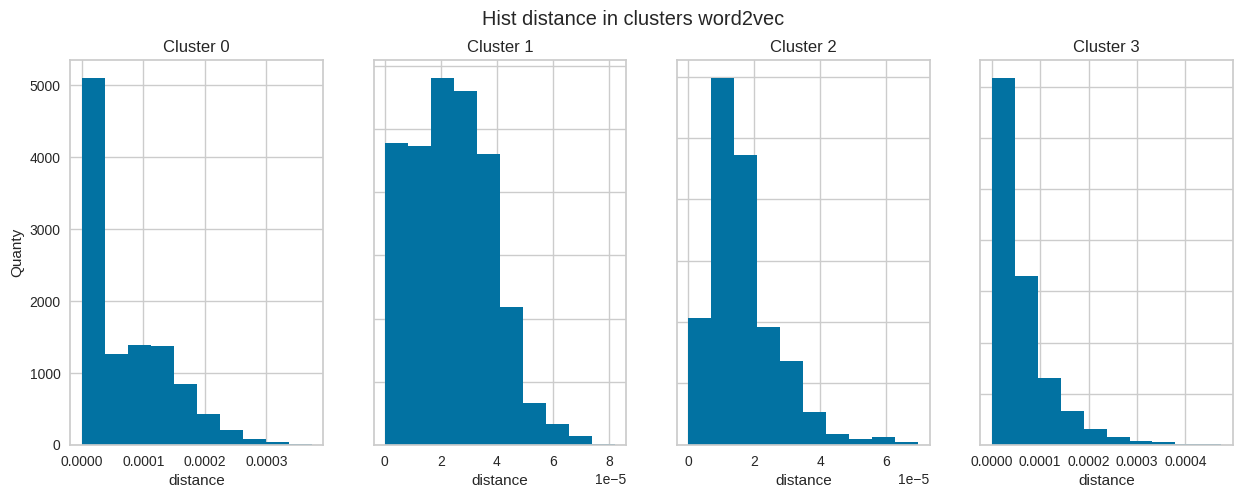

In [24]:
# составим матрицу внутри каждого кластера и выведим макс. расстояния пар
u_labels = sorted(products.cluster_w2v.value_counts().index)

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(1, len(u_labels), figsize=(15, 5))
fig.suptitle('Hist distance in clusters word2vec')

# идем по кластерам
for cls in u_labels:
    print(f'label_w2v {cls}')
    goods_cluster = products[products.cluster_w2v == cls].description.tolist()
    # читска описаний
    goods_cluster = clear_discription(goods_cluster)

    # Создание модели Word2Vec
    word2vec_model = Word2Vec([doc.lower().split() for doc in goods_cluster], min_count=1)
    # Преобразование текстовых документов в векторы Word2Vec
    word2vec_vectors_ = np.array([np.mean([word2vec_model.wv[word] for word in doc.lower().split() if word in word2vec_model.wv]
                                        or [np.zeros(word2vec_model.vector_size)], axis=0)
                                for doc in goods_cluster])
    # Нормализация векторов по строкам (приведение к единичной длине)
    normalized_vectors = word2vec_vectors_ / np.linalg.norm(word2vec_vectors_, axis=1, keepdims=True)
    # Вычисление косинусного расстояния
    cosine_dist_w2v = cosine_distances(normalized_vectors)

    print(f'max_cosdist_w2v {cosine_dist_w2v.max()}\n')
    # cписок парных косинусного расстояния
    pair_dist = pdist(word2vec_vectors_, 'cosine')
    axs[cls].set_title(f'Cluster {cls}')
    axs[cls].hist(pair_dist)

# подписи осей
for ax in axs.flat:
    ax.set(xlabel='distance', ylabel='Quanty')
# уберем лишние надписи на осях
for ax in axs.flat:
    ax.label_outer()


### Отрисуем с PCA

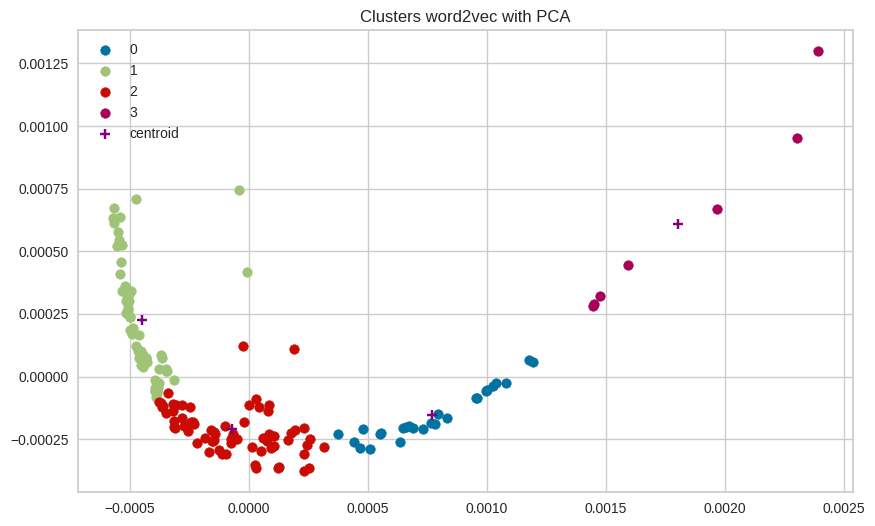

In [25]:
from sklearn.decomposition import PCA

pca = PCA(2)
#Transform the data
transform = pca.fit_transform(cosine_dist_w2v)
kmeans = KMeans(n_clusters= elbow_clusters)
label = kmeans.fit_predict(transform)

#plotting the results:

plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i, 0],
                transform[label == i, 1] ,
                label = i)
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            color='purple',marker='+',
            label='centroid')
plt.legend()
plt.title('Clusters word2vec with PCA')
plt.show()

## with cosine_dist_tfidf_word2vec

### Матрицы косинусных расстояний из tfidf_word2vec

In [26]:
# Нормализация векторов по строкам (приведение к единичной длине)
normalized_vectors = tfidf_w2v_vectors / np.linalg.norm(tfidf_w2v_vectors, axis=1, keepdims=True)

# Вычисление косинусного расстояния
cosine_dist_tfidf_w2v = cosine_distances(normalized_vectors)

# Вывод матрицы косинусных расстояний
print("Матрица косинусных расстояний tfidf_w2v:")
print(cosine_dist_tfidf_w2v)

Матрица косинусных расстояний tfidf_w2v:
[[0.         0.04874452 0.05244721 ... 0.06928278 0.05376027 0.05158223]
 [0.04874452 0.         0.03453028 ... 0.08346872 0.05876367 0.05891505]
 [0.05244721 0.03453028 0.         ... 0.06987197 0.05890908 0.05837619]
 ...
 [0.06928278 0.08346872 0.06987197 ... 0.         0.08401007 0.08191904]
 [0.05376027 0.05876367 0.05890908 ... 0.08401007 0.         0.03296887]
 [0.05158223 0.05891505 0.05837619 ... 0.08191904 0.03296887 0.        ]]


### Поиск оптимального к-ва кластеров

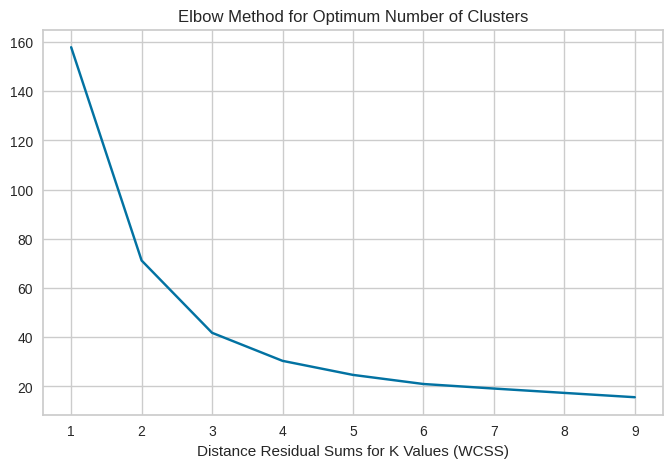

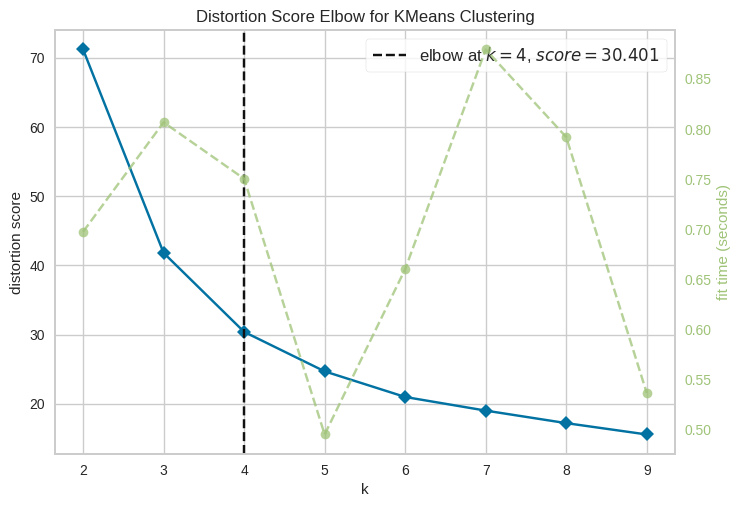

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(cosine_dist_tfidf_w2v)
    ssd.append(kmeans.inertia_)

ssd
fig = plt.figure(figsize=(8, 5))
plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 10))
visu.fit(cosine_dist_tfidf_w2v)
visu.show()

In [28]:
elbow_clusters = visu.elbow_value_
print(f'Best elbow quanty cluster {elbow_clusters}\n')

kmeans = KMeans(n_clusters=elbow_clusters).fit(cosine_dist_tfidf_w2v)
clusters = kmeans.labels_

products["cluster_tfidf_w2v"] = clusters
products.head()

Best elbow quanty cluster 4



,description,cluster_tfidf,cluster_w2v,cluster_tfidf_w2v
id,,,,
1,Active classic boxers - There's a reason why o...,2,3,1
2,Active sport boxer briefs - Skinning up Glory ...,3,3,1
3,Active sport briefs - These superbreathable no...,3,3,1
4,"Alpine guide pants - Skin in, climb ice, switc...",1,0,0
5,"Alpine wind jkt - On high ridges, steep ice an...",1,0,0


In [29]:
products.cluster_tfidf_w2v.value_counts()

1    148
0    136
2    118
3     98
Name: cluster_tfidf_w2v, dtype: int64

In [30]:
for cls in products.cluster_tfidf_w2v.value_counts().index:
  print(f'label_tfidf_w2v {cls}')
  print(products[products.cluster_tfidf_w2v == cls].sample(5).description)
  print()


label_tfidf_w2v 1
id
441    Cap 3 crew - Capilene 3, the most versatile an...
497    Cap 2 crew - This crew takes the edge off fick...
260    Merino 1 crew - Our lightest merino layer, thi...
474    Baby synch cardigan - Springtime temperatures ...
231    Tranquila capri leggings - Even in the crux yo...
Name: description, dtype: object

label_tfidf_w2v 0
id
255    Solid sunamee btm - Stay-put Sunamees fit stra...
220    Solid betina btm - Our fullest coverage bottom...
143    Traverse jkt - Training routine number 47: bic...
240    Print bayonne btm - The low-rise Bayonne Botto...
187    Inter-continental capris - Inter-Continental C...
Name: description, dtype: object

label_tfidf_w2v 2
id
71     Live simply bug t-shirt - In nature, live orga...
251    Simply organic top - When Spring's first bloss...
108    Reg fit organic ctn jeans-long - 100% organic ...
471    Baby live simply seal t-shirt - Swim, fish, ha...
288    North coast t-shirt - The North Coast T-Shirt ...
Name: descript

### Посмотрим распределение расстояний в кластерах

label_tfidf_w2v 0
max_cosdist_tfidf_w2v 0.24625902827439405

label_tfidf_w2v 1
max_cosdist_tfidf_w2v 0.23253815522548182

label_tfidf_w2v 2
max_cosdist_tfidf_w2v 0.23015873009509769

label_tfidf_w2v 3
max_cosdist_tfidf_w2v 0.22819002230316132



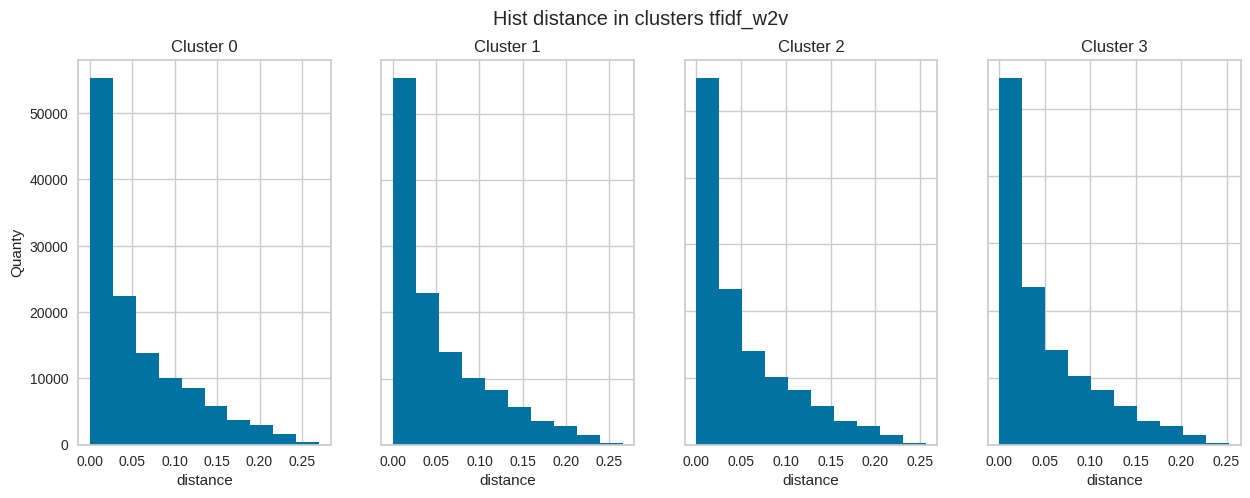

In [31]:
# составим матрицу внутри каждого кластера и выведим макс. расстояния пар
u_labels = sorted(products.cluster_tfidf_w2v.value_counts().index)

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(1, len(u_labels), figsize=(15, 5))
fig.suptitle('Hist distance in clusters tfidf_w2v')

# идем по кластерам
for cls in u_labels:
    print(f'label_tfidf_w2v {cls}')

    # Создание TF-IDF векторизатора
    tfidf_vectorizer = TfidfVectorizer()

    goods_cluster = products.description.tolist()
    # читска описаний
    goods_cluster = clear_discription(goods_cluster)

    # Преобразование текстовых документов в матрицу TF-IDF
    tfidf_matrix_ = tfidf_vectorizer.fit_transform(goods_cluster).toarray()

    # Создание модели Word2Vec
    word2vec_model = Word2Vec([doc.lower().split() for doc in goods_cluster], min_count=1)

    # Преобразование текстовых документов в векторы Word2Vec
    word2vec_vectors_ = np.array([np.mean([word2vec_model.wv[word] for word in doc.lower().split() if word in word2vec_model.wv]
                                        or [np.zeros(word2vec_model.vector_size)], axis=0)
                                for doc in goods_cluster])
    # Соединяем в расширенные векторы из Word2Vec и TF_IDF
    tfidf_w2v_vectors_ = np.hstack((tfidf_matrix_, word2vec_vectors_))

    # Нормализация векторов по строкам (приведение к единичной длине)
    normalized_vectors = tfidf_w2v_vectors_ / np.linalg.norm(tfidf_w2v_vectors_, axis=1, keepdims=True)
    # Вычисление косинусного расстояния
    cosine_dist_tfidf_w2v = cosine_distances(normalized_vectors)

    print(f'max_cosdist_tfidf_w2v {cosine_dist_tfidf_w2v.max()}\n')

    # cписок пар косинусного расстояния
    pair_dist = pdist(cosine_dist_tfidf_w2v, 'cosine')
    axs[cls].set_title(f'Cluster {cls}')
    axs[cls].hist(pair_dist)

# подписи осей
for ax in axs.flat:
    ax.set(xlabel='distance', ylabel='Quanty')
# уберем лишние надписи на осях
for ax in axs.flat:
    ax.label_outer()


### Отрисуем с PCA

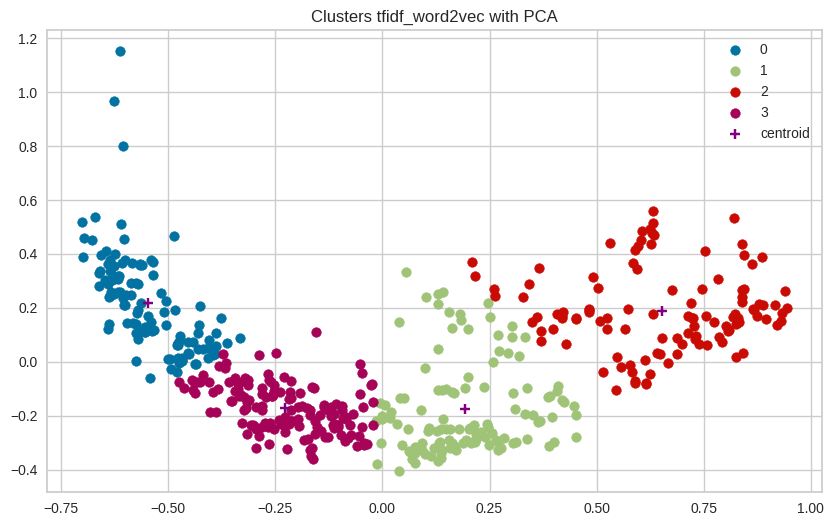

In [32]:
from sklearn.decomposition import PCA

pca = PCA(2)
#Transform the data
transform = pca.fit_transform(cosine_dist_tfidf_w2v)
kmeans = KMeans(n_clusters= elbow_clusters)
label = kmeans.fit_predict(transform)

#plotting the results:
plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i, 0],
                transform[label == i, 1] ,
                label = i)
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            color='purple',marker='+',
            label='centroid')
plt.legend()
plt.title('Clusters tfidf_word2vec with PCA')
plt.show()

# Вывод данных

В проведенных экспериментах наименьшеее максимальное расстоянене внутри класстера выходит на чистых W2V векторах

In [33]:
import copy
# словарь списков id схожих товаров по ключу id
dict_closers = dict()
# идем по кластерам
for label in np.unique(products.cluster_w2v.to_numpy()):
  # список id кластера
  id_goods_cluster = list(products[products.cluster_w2v == label].index)
  # идем по id внутри кластера
  for id in id_goods_cluster:
    # убираем id товара из списка с копированем
    sim_goods = copy.deepcopy(id_goods_cluster)
    sim_goods.remove(id)
    # вносим в словарь
    dict_closers[id] = sim_goods

In [34]:
#смотрим по случайным id
for id in products.sample(5).index:
  print(f'Для id = {id} список id схожих {dict_closers[id]}\n')
  print()

Для id = 381 список id схожих [4, 5, 6, 8, 12, 15, 16, 29, 43, 44, 45, 46, 51, 52, 57, 59, 75, 77, 79, 80, 81, 82, 97, 99, 100, 113, 114, 115, 120, 129, 133, 136, 137, 146, 147, 148, 149, 155, 156, 159, 166, 168, 184, 187, 188, 195, 196, 205, 207, 208, 209, 211, 213, 214, 216, 220, 221, 222, 223, 224, 226, 232, 240, 241, 242, 243, 244, 246, 252, 253, 254, 255, 256, 258, 261, 262, 263, 267, 268, 270, 271, 272, 273, 278, 280, 284, 291, 293, 300, 301, 302, 304, 305, 306, 308, 316, 325, 328, 330, 331, 338, 339, 343, 344, 353, 361, 379, 383, 384, 385, 386, 387, 395, 398, 402, 405, 408, 409, 410, 414, 415, 416, 418, 420, 422, 425, 427, 429, 434, 435, 438, 444, 445, 449, 450, 454, 457, 458, 465, 466, 469, 480, 484, 485, 490, 498]


Для id = 206 список id схожих [1, 2, 3, 9, 14, 18, 19, 20, 22, 23, 24, 25, 27, 28, 30, 32, 34, 38, 39, 47, 61, 62, 66, 70, 74, 76, 78, 87, 88, 89, 90, 91, 92, 102, 105, 106, 111, 112, 117, 121, 125, 127, 132, 145, 160, 161, 163, 164, 165, 171, 172, 173, 174, 175, 1

## С использованием hierarchy и threshold

In [35]:
# Нормализация векторов по строкам (приведение к единичной длине)
normalized_vectors = word2vec_vectors / np.linalg.norm(word2vec_vectors, axis=1, keepdims=True)

# Вычисление косинусного расстояния
cosine_dist_w2v = cosine_distances(normalized_vectors)

# Вывод матрицы косинусных расстояний
print("Матрица косинусных расстояний w2v:")
print(cosine_dist_w2v)

Матрица косинусных расстояний w2v:
[[0.         0.00078344 0.00175595 ... 0.02152312 0.00321847 0.00209689]
 [0.00078344 0.         0.00143081 ... 0.02655089 0.00142628 0.00078338]
 [0.00175595 0.00143081 0.         ... 0.01852292 0.00255287 0.00372869]
 ...
 [0.02152312 0.02655089 0.01852292 ... 0.         0.03260076 0.03315413]
 [0.00321847 0.00142628 0.00255287 ... 0.03260076 0.         0.00129843]
 [0.00209689 0.00078338 0.00372869 ... 0.03315413 0.00129843 0.        ]]


In [36]:
from scipy.cluster.hierarchy import fcluster, linkage

# Получение матрицы связей
linkage_matrix = linkage(cosine_dist_w2v, method='average', metric='cosine')

# Задание трешхолда
threshold = 0.1

# Получение кластеров на основе матрицы связей и трешхолда
labels_threshold = fcluster(linkage_matrix, threshold, criterion='distance')


products['cluster_w2v_threshold'] = np.array(labels_threshold)
products

,description,cluster_tfidf,cluster_w2v,cluster_tfidf_w2v,cluster_w2v_threshold
id,,,,,
1,Active classic boxers - There's a reason why o...,2,3,1,2
2,Active sport boxer briefs - Skinning up Glory ...,3,3,1,2
3,Active sport briefs - These superbreathable no...,3,3,1,2
4,"Alpine guide pants - Skin in, climb ice, switc...",1,0,0,1
5,"Alpine wind jkt - On high ridges, steep ice an...",1,0,0,1
...,...,...,...,...,...
496,Cap 2 bottoms - Cut loose from the maddening c...,2,3,1,4
497,Cap 2 crew - This crew takes the edge off fick...,2,3,1,4
498,All-time shell - No need to use that morning T...,1,0,0,3


In [37]:
print(products.cluster_tfidf.value_counts())
print(products.cluster_tfidf_w2v.value_counts())
print(products.cluster_tfidf_w2v.value_counts())
print(products.cluster_w2v_threshold.value_counts())

3    230
1    154
0     60
2     56
Name: cluster_tfidf, dtype: int64
1    148
0    136
2    118
3     98
Name: cluster_tfidf_w2v, dtype: int64
1    148
0    136
2    118
3     98
Name: cluster_tfidf_w2v, dtype: int64
1    214
2    210
4     69
3      7
Name: cluster_w2v_threshold, dtype: int64


In [38]:
import copy
# словарь списков id схожих товаров по ключу id
dict_closers = dict()
# идем по кластерам
for label in np.unique(products.cluster_w2v_threshold.to_numpy()):
  # список id кластера
  id_goods_cluster = list(products[products.cluster_w2v_threshold == label].index)
  # идем по id внутри кластера
  for id in id_goods_cluster:
    # убираем id товара из списка с копированем
    sim_goods = copy.deepcopy(id_goods_cluster)
    sim_goods.remove(id)
    # вносим в словарь
    dict_closers[id] = sim_goods

In [39]:
#смотрим по случайным id
for id in products.sample(5).index:
  print(f'Для id = {id} список id схожих {dict_closers[id]}\n')
  print()

Для id = 442 список id схожих [9, 16, 22, 23, 24, 34, 57, 74, 82, 87, 88, 89, 90, 105, 111, 112, 117, 145, 160, 161, 165, 173, 174, 175, 189, 190, 192, 195, 196, 200, 201, 202, 203, 206, 215, 219, 226, 247, 255, 257, 258, 262, 263, 266, 269, 277, 283, 291, 309, 314, 317, 359, 360, 378, 380, 399, 400, 406, 407, 412, 418, 426, 441, 446, 477, 478, 496, 497]


Для id = 452 список id схожих [1, 2, 3, 11, 14, 18, 19, 20, 21, 25, 26, 27, 28, 30, 32, 36, 37, 38, 39, 40, 41, 47, 56, 58, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 76, 78, 91, 95, 98, 101, 102, 103, 106, 108, 109, 110, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 132, 138, 139, 140, 144, 151, 152, 162, 163, 164, 167, 169, 170, 171, 172, 176, 177, 178, 180, 181, 182, 183, 185, 186, 191, 193, 194, 198, 199, 218, 225, 227, 228, 229, 230, 231, 233, 234, 235, 236, 237, 239, 245, 248, 249, 250, 251, 259, 260, 264, 265, 276, 279, 285, 286, 287, 288, 289, 290, 292, 294, 295, 296, 297, 298, 303, 307, 310, 311, 313, 315, 318,